In [2]:
#Hydrology Sonification 2.0, Thanks Allison for writing all the data processing side already.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import os

from midiutil import MIDIFile

%matplotlib inline

In [3]:
path = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(path)

df_precip = pd.read_excel("{}/data/Precip_HJASite101.xlsx".format(parent_dir), parse_dates=[7])
print('Total Precipitation Entries:', df_precip.size)

df_clearlake = pd.read_excel("{}/data/ClearLake.xls".format(parent_dir), header=27)
print('Clear Lake Discharge Entries:', df_clearlake.size)

df_lookout = pd.read_excel("{}/data/LOOKOUT_GSLOOK.xlsx".format(parent_dir), parse_dates= {"date" : ["year","month","day"]})
print('Lookout Ck Entries:', df_lookout.size)


Total Precipitation Entries: 222332
Clear Lake Discharge Entries: 175590
Lookout Ck Entries: 275297


In [4]:
print(df_precip.head(3), '\n')
print(df_clearlake.head(3), '\n')
print(df_lookout.head(3))

  DBCODE  ENTITY SITECODE PRECIP_METHOD  HEIGHT QC_LEVEL PROBE_CODE  \
0  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   
1  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   
2  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   

        date  PRECIP_TOT_DAY PRECIP_TOT_FLAG EVENT_CODE  
0 1957-10-01             4.1               A     METHOD  
1 1957-10-02            27.4               A        NaN  
2 1957-10-03            22.9               A        NaN   

  agency_cd   site_no       date  discharge 01_00060_00003_cd
0      USGS  14158500 1912-10-01      256.0                 A
1      USGS  14158500 1912-10-02      254.0                 A
2      USGS  14158500 1912-10-03      252.0                 A 

        date STCODE  FORMAT SITECODE  WATERYEAR  MEAN_Q_cfs  MAX_Q  MIN_Q  \
0 1949-10-01  HF004       2   GSLOOK       1950        11.0   11.0   11.0   
1 1949-10-02  HF004       2   GSLOOK       1950        11.0   11.0   11.0   


In [5]:
#we need to sort the data by data
dfp=df_precip.sort_values(by=['date'])
dfc=df_clearlake.sort_values(by=['date'])
dfl=df_lookout.sort_values(by=['date'])

# rename some of the columns that we will be working with
dfp = dfp.rename(columns={'PRECIP_TOT_DAY': 'HJA Precipitation in mm/day'})
dfc = dfc.rename(columns={'discharge': 'Clear Lake discharge in cfs'})
dfl = dfl.rename(columns={'MEAN_Q_cfs': 'Lookout Ck discharge in cfs'})

#check that the sampling rate is same
dtp = (dfp.date[1] - dfp.date[0])
dtl = (dfl.date[1] - dfl.date[0])
dtc = (dfc.date[1] - dfc.date[0])
print(dtp,dtc,dtl)

1 days 00:00:00 1 days 00:00:00 1 days 00:00:00


2013-01-31 00:00:00
2008-11-23 00:00:00
2018-04-08 00:00:00


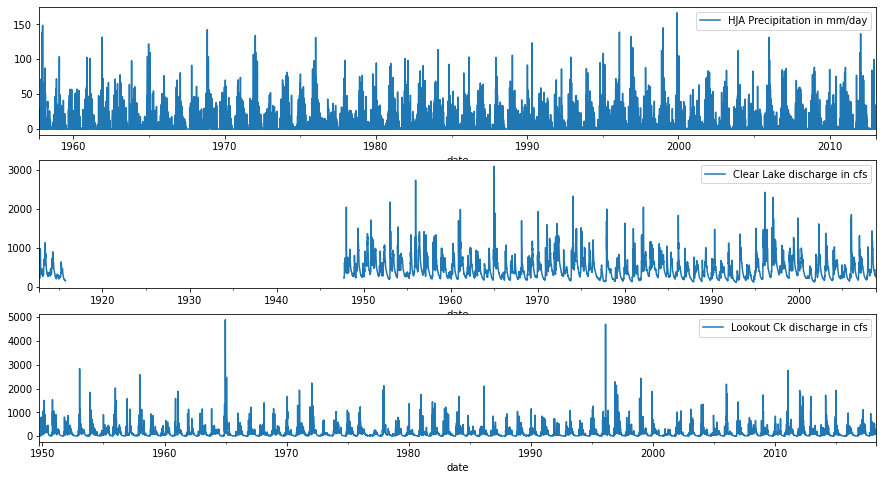

In [6]:
fig,ax = plt.subplots(3,figsize=(15,8))
ax[0]=dfp.plot(x="date", y="HJA Precipitation in mm/day",ax=ax[0])
ax[1]=dfc.plot(x="date", y="Clear Lake discharge in cfs",ax=ax[1])
ax[2]=dfl.plot(x="date", y="Lookout Ck discharge in cfs",ax=ax[2])


#plt.show()
print(dfp['date'].max())
print(dfc['date'].max())
print(dfl['date'].max())

18262 18262 18262
18262 18262 18262


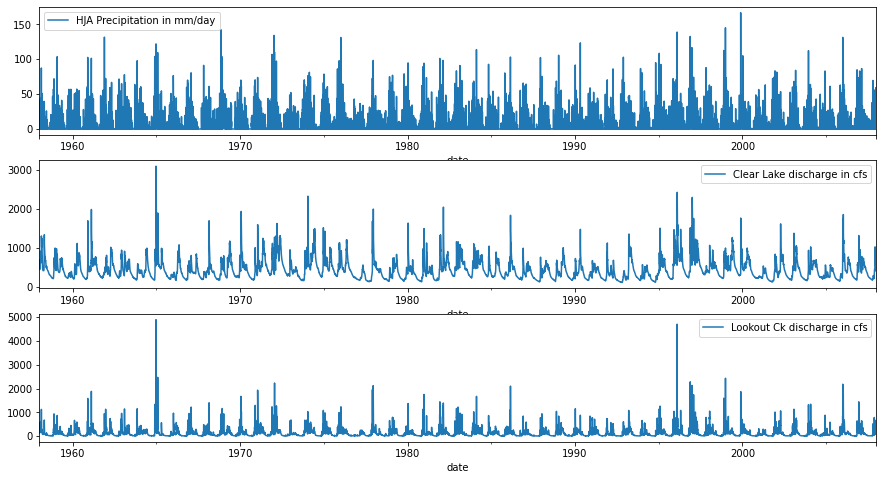

In [7]:
#find common time frame between the datasets
start = '1958-01-01'
end = '2008-01-01'

conditionP = (dfp['date'] > start) & (dfp['date'] <= end)
dp=dfp.loc[conditionP]
conditionL = (dfl['date'] > start) & (dfl['date'] <= end)
dl=dfl.loc[conditionL]
conditionC = (dfc['date'] > start) & (dfc['date'] <= end)
dc=dfc.loc[conditionC]

print(sum(conditionP==True),sum(conditionC==True),sum(conditionL==True))
print(dp.shape[0],dc.shape[0],dl.shape[0])

#plot it up
fig,ax = plt.subplots(3,figsize=(15,8));
ax[0]=dp.plot(x="date", y="HJA Precipitation in mm/day",ax=ax[0]);
ax[1]=dc.plot(x="date", y="Clear Lake discharge in cfs",ax=ax[1]);
ax[2]=dl.plot(x="date", y="Lookout Ck discharge in cfs",ax=ax[2]);
fig.savefig('Cascades_Q_Lookout_ClearLake.png')

In [8]:
# compile the list of dataframes we want to merge
data_frames = [dp, dc, dl]
#merge them using the common date column
df_mergedALL = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)

#then reduce clutter by making a final dataframe that just has the quantities of interest
df_pcl = df_mergedALL[['date','HJA Precipitation in mm/day', 'Clear Lake discharge in cfs', 'Lookout Ck discharge in cfs']].copy()
df_pcl.head(3)

,date,HJA Precipitation in mm/day,Clear Lake discharge in cfs,Lookout Ck discharge in cfs
0,1958-01-02,3.8,686.0,169.0
1,1958-01-03,0.0,642.0,150.0
2,1958-01-04,0.0,606.0,134.0


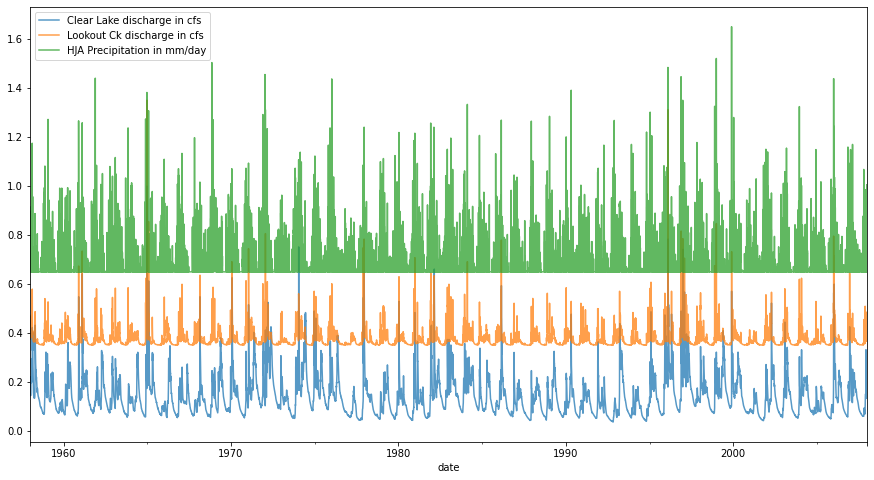

In [9]:
#lets make this a little more readable
#df_norm=(df_pcl-df_pcl.min())/(df_pcl.max()-df_pcl.min())
df_norm=df_pcl.copy()
df_norm["Clear Lake discharge in cfs"] = df_norm["Clear Lake discharge in cfs"]  / df_norm["Clear Lake discharge in cfs"].abs().max()
df_norm["Lookout Ck discharge in cfs"] = df_norm["Lookout Ck discharge in cfs"]  / df_norm["Lookout Ck discharge in cfs"].abs().max() + .35
df_norm["HJA Precipitation in mm/day"] = df_norm["HJA Precipitation in mm/day"]  / df_norm["HJA Precipitation in mm/day"].abs().max() + .65


fig,ax = plt.subplots(figsize=(15,8));
ax=df_norm.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs", "HJA Precipitation in mm/day"],ax=ax, alpha=0.75);

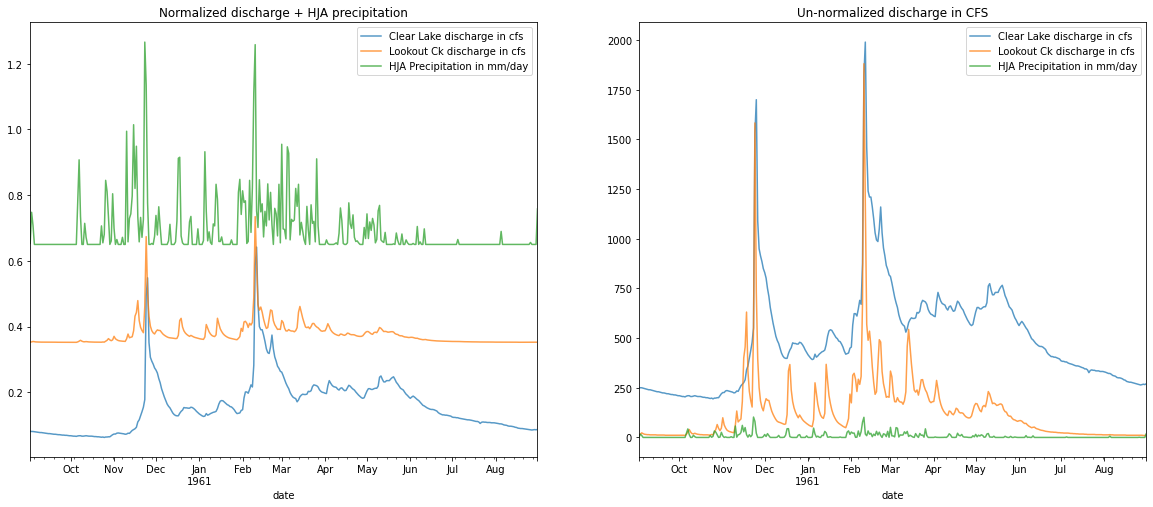

In [10]:
# To highlight the differences in discharge rate I'm going to try two things. Note After Note Overlapping Movement
#   Using 2 different instruments. Overlapping each other.
#   Then to have a call & response type melody generation
#   The Rain will still be mapped to the cutoff of a Drone

# I'm going to start by just getting a year done, then I'll go for 5 year segments to generate the whole thing.

start_date = '1960-09-01'
end_date = '1961-08-31'

condition = (df_norm['date'] > start_date) & (df_norm['date'] <= end_date)
df_norm_ofdaterange=df_norm.loc[condition] #This is the data we will process for each section of a year.
df_ofdaterange=df_pcl.loc[condition]

fig,ax = plt.subplots(1,2,figsize=(20,8))
ax[0]=df_norm_ofdaterange.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs", "HJA Precipitation in mm/day"],ax=ax[0], alpha=0.75)
ax[1]=df_ofdaterange.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs", "HJA Precipitation in mm/day"],ax=ax[1], alpha=0.75)

ax[1].title.set_text('Un-normalized discharge in CFS')
ax[0].title.set_text('Normalized discharge + HJA precipitation')    

In [11]:
# Setting Our Functions

def set_midi_notes_for_mode(start_note, octaves, mode):
    #Returns a list of Diatonic Notes in the Mode
    #Returns a 2nd list of Accidental Notes not in the Mode
    
    modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
    }
    
    diatonics = []
    accidentals = []
    
    for octave in range(octaves):
        note = start_note + (12*octave) #first octave = 0, 2nd=1, etc
        
        for step in modes[mode]:
            diatonics.append(note)
            note = note + step
    last_note = start_note + (octaves*12) #sets last note
    diatonics.append(last_note) #there must be a better way to do this
    
    for i in range(octaves*12): #in range of all semitones
        note = start_note + i
        
        if note not in diatonics:
            accidentals.append(note)
            
    return diatonics, accidentals

def alt_basic_diatonic_midifile(bpm, note_duration, midi_data):
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = 0
    
    mymidi = MIDIFile(1, eventtime_is_ticks=True)
    mymidi.addTempo(track, miditime, bpm)
    
    
    #Some calculations to approximate length in seconds
    # qnps = 1/(bpm/60.)*4 #quarter per sec
    spq = 1/(bpm/60.)
    note_time = note_duration / 960.
    tot_notetime = spq*note_time
    print('File Length:', len(midi_data)*(tot_notetime), 'seconds')
    
    for note in range(len(midi_data)):
        mymidi.addNote(track, channel, int(midi_data[note]), miditime, note_duration, velocity)
        miditime += note_duration
    
    return mymidi

#Let's get note stuff settled.

start_note = 48 #c3
octaves = 2
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)
print('Chosen Diatonics:', diatonics)

Chosen Diatonics: [48, 50, 52, 53, 55, 57, 59, 60, 62, 64, 65, 67, 69, 71, 72]


Length of CL data in Range: 364
Length of LK data in Range: 364
Sample Size for Notes 12
Clear Lake Midi [50. 48. 48. 53. 53. 69. 57. 57. 57. 52. 50. 50.]
Lookout Midi [65. 65. 65. 67. 67. 72. 69. 67. 67. 65. 65. 65.]


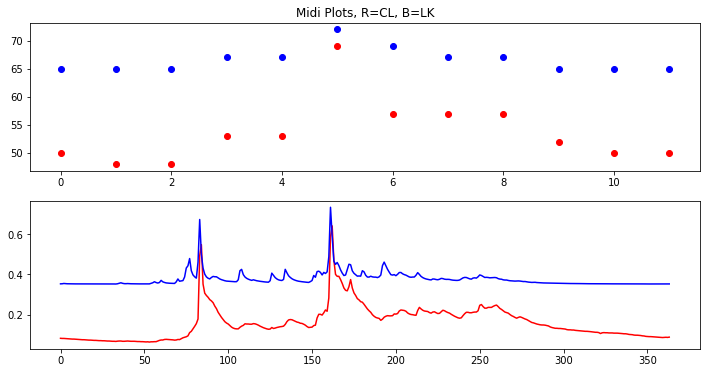

In [12]:
#Time to map notes

cl_data = df_norm_ofdaterange['Clear Lake discharge in cfs'].values
print('Length of CL data in Range:', len(cl_data))
lk_data = df_norm_ofdaterange['Lookout Ck discharge in cfs'].values
print('Length of LK data in Range:', len(lk_data))

target_n = 12
print('Sample Size for Notes', target_n)
step = int(len(cl_data)/target_n)
slices = np.linspace(0, 365, target_n)

data = np.zeros((2, target_n))

for i in range(len(slices)-1):
    data[0][i]=(cl_data[int(slices[i])])
    data[1][i]=(lk_data[int(slices[i])])
data[0][-1]=cl_data[-1]
data[1][-1]=lk_data[-1]
#Putting year data into a nice little array for my sanity


nout = np.interp(data, (np.min(data), np.max(data)), (0, len(diatonics)-1))
out = np.zeros((len(nout), len(nout[0]))) #Set official out array

for i in range(len(nout)):
    for j in range(len(nout[0])):
        s = int(np.round(nout[i][j]))
        out[i,j] = diatonics[s]
        
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0].plot(out[0], 'ro')
ax[0].plot(out[1], 'bo')
ax[1].plot(cl_data, 'r')
ax[1].plot(lk_data, 'b')
ax[0].set_title('Midi Plots, R=CL, B=LK')

print('Clear Lake Midi', out[0])
print('Lookout Midi', out[1])

In [13]:
#Now we need to work out time parameters here so we can make a continuous Rain Automation File and 2 distinct midi files for the Discharge Melodies.

bpm = 120
spb = 1/(120/60.)

note_duration = 960/2 #We'll start with 1/8 notes. That makes each year 1.5 bars/12 notes long if we sample monthly
total_ticks_guess = (note_duration * target_n)

actual_scoretime = (total_ticks_guess/960)*spb
print('Attempting Melody Time of(sec): ', actual_scoretime)

rain_time = actual_scoretime*2 #For both melodies
print('Raintime: ', rain_time, 'As Ticks', note_duration*12)

Attempting Melody Time of(sec):  3.0
Raintime:  6.0 As Ticks 5760.0


In [14]:
cl_test_1960 = alt_basic_diatonic_midifile(bpm, int(note_duration), out[0])
lk_test_1960 = alt_basic_diatonic_midifile(bpm, int(note_duration), out[1])

with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('cl_1960_12_2'), "wb") as output_file:
    cl_test_1960.writeFile(output_file)
    
with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('lk_1960_12_2'), "wb") as output_file2:
    lk_test_1960.writeFile(output_file2)
    
#Excellent. Now to make a generator for each of these.

File Length: 3.0 seconds
File Length: 3.0 seconds


In [77]:
#total_daterange_start = '1960-07-01'
#total_daterange_end = '2005-06-30'

#Short Range For Testing
total_daterange_start = '1960-07-01'
total_daterange_end = '1965-06-30'

#For Year in Each Date Range Make a Midi File of the range.
def loc_on(start_date, end_date, df):
    #Locks on to a set time of dates
    
    condition = (df['date'] > start_date) & (df['date'] <= end_date)
    return_df=df.loc[condition] 
    
    return return_df

from datetime import datetime # I don't know how to use panda dates so I'd rather just take the round about way and use datetime
def get_years(total_start_date, total_end_date):
    #returns a list of strings to use as date entries for loc_on
    tstart = datetime.strptime(total_start_date, '%Y-%m-%d')
    tend = datetime.strptime(total_end_date, '%Y-%m-%d')
    
    all_years = []
    for y in range(tstart.year, tend.year+1):
        all_years.append(y)
    
    return all_years

years = get_years(total_daterange_start, total_daterange_end)
print('All the Years Going By:', years)

start_note = 48 #c3
octaves = 3
mode = 'ionian'
diatonics, accidentals = set_midi_notes_for_mode(start_note, octaves, mode)
print('New Diatonics:', diatonics)

All the Years Going By: [1960, 1961, 1962, 1963, 1964, 1965]
New Diatonics: [48, 50, 52, 53, 55, 57, 59, 60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 83, 84]


Date Range: 1960-06-30 1961-06-30
Date Range: 1961-06-30 1962-06-30
Date Range: 1962-06-30 1963-06-30
Date Range: 1963-06-30 1964-06-30
Date Range: 1964-06-30 1965-06-30


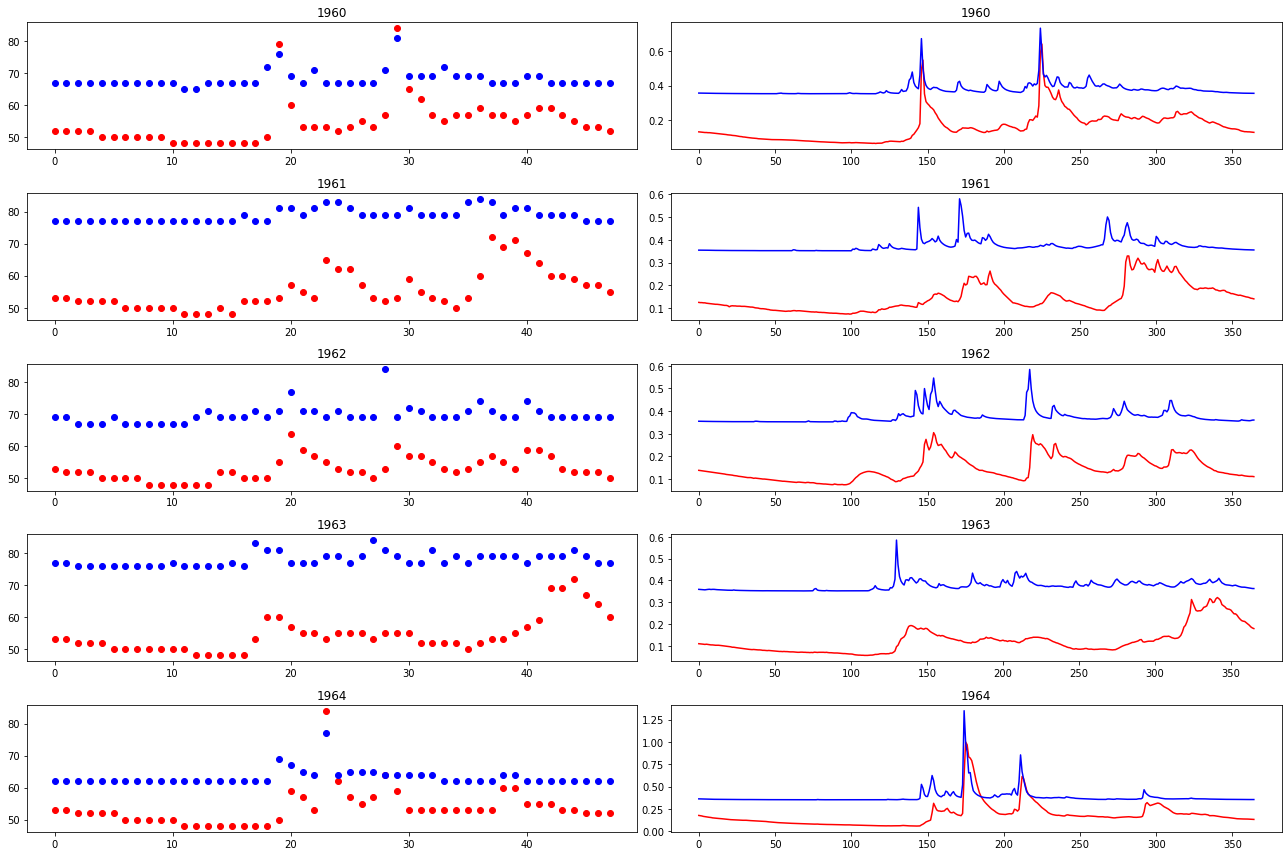

In [81]:
#Constructing a Monster of a function

#Getting the full range for midi mapping.
data_ranges = [df_norm['Clear Lake discharge in cfs'].min(), 
               df_norm['Clear Lake discharge in cfs'].max(),
               df_norm['Lookout Ck discharge in cfs'].min(), 
               df_norm['Lookout Ck discharge in cfs'].max()]
datamin = min(data_ranges)
datamax = max(data_ranges)

midi_dict_allyears = {} #Making a dictionary with each year and array
temp_data_agg = {} #Just for plotting purposes



target_n = 12*4 #Change this number, in samples per year




fig, ax =plt.subplots(len(years)-1, 2, figsize=(18,12))
for year in range(len(years)-1):
    start_date = '{}-06-30'.format(years[year])
    end_date = '{}-06-30'.format(years[year+1])
    print('Date Range:', start_date, end_date)
    
    data_4range = loc_on(start_date, end_date, df_norm)
    cl_data = data_4range['Clear Lake discharge in cfs'].values
    lk_data = data_4range['Lookout Ck discharge in cfs'].values
    
    #Getting Sample
    step = int(len(cl_data)/target_n)
    slices = np.linspace(0, 365, target_n)

    #Set Outputs
    data = np.zeros((2, target_n))
    for i in range(len(slices)-1):
        data[0][i]=(cl_data[int(slices[i])])
        data[1][i]=(lk_data[int(slices[i])])
    data[0][-1]=cl_data[-1]
    data[1][-1]=lk_data[-1]
    #nout = np.interp(data, (datamin, datamax), (0, len(diatonics)-1)) #Use this if you want year relative maps
    
    nout = np.interp(data, (np.min(data), np.max(data)), (0, len(diatonics)-1)) #Use this if you dont want relative maps
    
    out = np.zeros((len(nout), len(nout[0]))) #Set official out array

    for i in range(len(nout)):
        for j in range(len(nout[0])):
            s = int(np.round(nout[i][j]))
            out[i,j] = diatonics[s]
            
    midi_dict_allyears[years[year]] = out #THe final Out
    temp_data_agg[years[year]] = [cl_data, lk_data] #Temporary
    
    ax[year][0].set_title(years[year])
    ax[year][0].plot(out[0], 'ro')
    ax[year][0].plot(out[1], 'bo')
    
    ax[year][1].set_title(years[year])
    ax[year][1].plot(cl_data, 'r')
    ax[year][1].plot(lk_data, 'b')
plt.tight_layout()

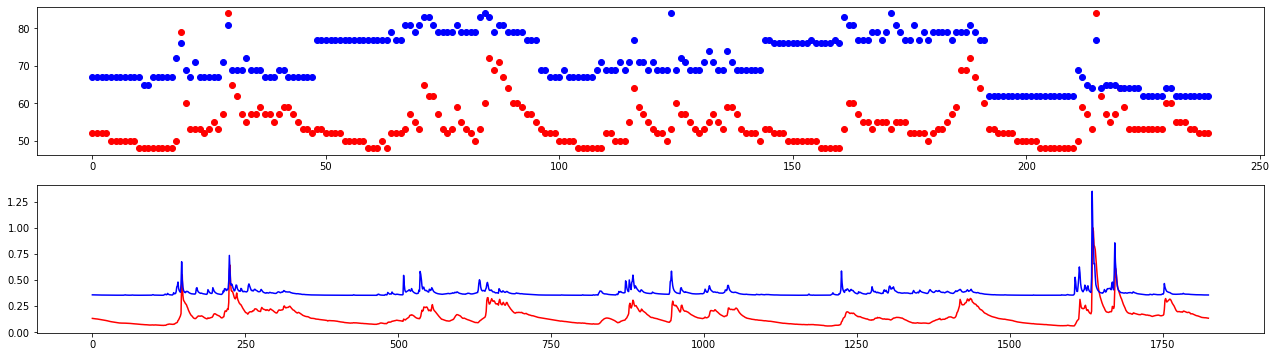

In [82]:
#Let's look at what we made in a different way

clfull_out = []
lkfull_out = []
cl_data_total = []
lk_data_total = []


for year in midi_dict_allyears.keys():
    clfull_out.extend(midi_dict_allyears[year][0])
    lkfull_out.extend(midi_dict_allyears[year][1])
    
    cl_data_total.extend(temp_data_agg[year][0])
    lk_data_total.extend(temp_data_agg[year][1])
    
fig, ax = plt.subplots(2, figsize=(22,6))
ax[0].plot(clfull_out, 'ro')
ax[0].plot(lkfull_out, 'bo')
ax[1].plot(cl_data_total, 'r')
ax[1].plot(lk_data_total, 'b')
    

In [96]:
#Let's make the files for the midi so we can get the time stuff sorted
bpm = 120
spb = 1/(120/60.)

note_duration = 960 #We'll start with 1/8 notes. 
total_ticks = (note_duration * target_n)
actual_scoretime = (total_ticks/960)*spb
print('Melody Time of(sec) per Year: ', actual_scoretime)
print('Total Length of All Files Combined for one discharge ({} years total): '.format(len(midi_dict_allyears)), actual_scoretime*len(midi_dict_allyears))
print('length of all call/responses:',actual_scoretime*len(midi_dict_allyears)*2)

#I think I would die if I outputted a million midi files, so instead lets just write 2 long ones. Thus we need an augmented write function.
def alt_basic_diatonic_midifile_withmiditime(midifile, bpm, note_duration, midi_data, miditime_start):
    #Writes as usual but takes miditime as a parameter.
    
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = miditime_start
    
    mymidi = midifile
    
    for note in range(len(midi_data)):
        mymidi.addNote(track, channel, int(midi_data[note]), miditime, note_duration, velocity)
        miditime += note_duration
    
    return mymidi, miditime

Melody Time of(sec) per Year:  24.0
Total Length of All Files Combined for one discharge (5 years total):  120.0
length of all call/responses: 240.0


In [101]:

miditime = 0
cl_midi = MIDIFile(1, eventtime_is_ticks=True) #Making CL file
cl_midi.addTempo(0, miditime, bpm)

lk_midi = MIDIFile(1, eventtime_is_ticks=True) #Making LK file
lk_midi.addTempo(0, miditime, bpm)

phrase_length = total_ticks
print('Each phrase contains {} ticks.'.format(phrase_length))

for year in midi_dict_allyears.keys():
    cl_midi, miditime = alt_basic_diatonic_midifile_withmiditime(cl_midi, bpm, int(note_duration), midi_dict_allyears[year][0], miditime)
    lk_midi, miditime = alt_basic_diatonic_midifile_withmiditime(lk_midi, bpm, int(note_duration), midi_dict_allyears[year][1], miditime)

with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('cl_longformTest'), "wb") as output_file:
    cl_midi.writeFile(output_file)
    
with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('lk_longformTest'), "wb") as output_file:
    lk_midi.writeFile(output_file)
    
#This is pretty alright but I'm not happy with it yet. I want a version that removes duplicate notes

Each phrase contains 46080 ticks.


In [151]:
def diatonic_midifile_destroy_duples(midifile, bpm, note_duration, midi_data, miditime_start):
    #Writes as usual but takes miditime as a parameter. Also if the note before is the same, just adds length to the note.
    track = 0
    channel = 0
    velocity = 100 #Constant for now
    miditime = miditime_start
    
    mymidi = midifile
    moving_duration = note_duration
    write_note = midi_data[0]
    
    for note in range(1, len(midi_data)):
        
        if midi_data[note] == midi_data[note-1]:
            moving_duration += note_duration
            
        elif midi_data[note] != midi_data[note-1]:
            mymidi.addNote(track, channel, int(write_note), miditime, moving_duration, velocity)
            miditime += moving_duration
            moving_duration = note_duration
            write_note = midi_data[note]
        
    mymidi.addNote(track, channel, int(write_note), miditime, moving_duration, velocity)
    miditime += moving_duration

    return mymidi, miditime

In [160]:
miditime = 0
clnod_midi = MIDIFile(1, eventtime_is_ticks=True) #Making CL file
clnod_midi.addTempo(0, miditime, bpm)

lknod_midi = MIDIFile(1, eventtime_is_ticks=True) #Making LK file
lknod_midi.addTempo(0, miditime, bpm)

for year in midi_dict_allyears.keys():
    clnod_midi, miditime = diatonic_midifile_destroy_duples(clnod_midi, bpm, int(note_duration), midi_dict_allyears[year][0], miditime)
    lknod_midi, miditime = diatonic_midifile_destroy_duples(lknod_midi, bpm, int(note_duration), midi_dict_allyears[year][1], miditime)

with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('cl_noduplesTest'), "wb") as output_file:
    clnod_midi.writeFile(output_file)
    
with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('lk_noduplesTest'), "wb") as output_file:
    lknod_midi.writeFile(output_file)
    
#Although a little slow these are a lot closer to what sounds good and followable.

Date Range: 1960-06-30 1961-06-30
Date Range: 1961-06-30 1962-06-30
Date Range: 1962-06-30 1963-06-30
Date Range: 1963-06-30 1964-06-30
Date Range: 1964-06-30 1965-06-30


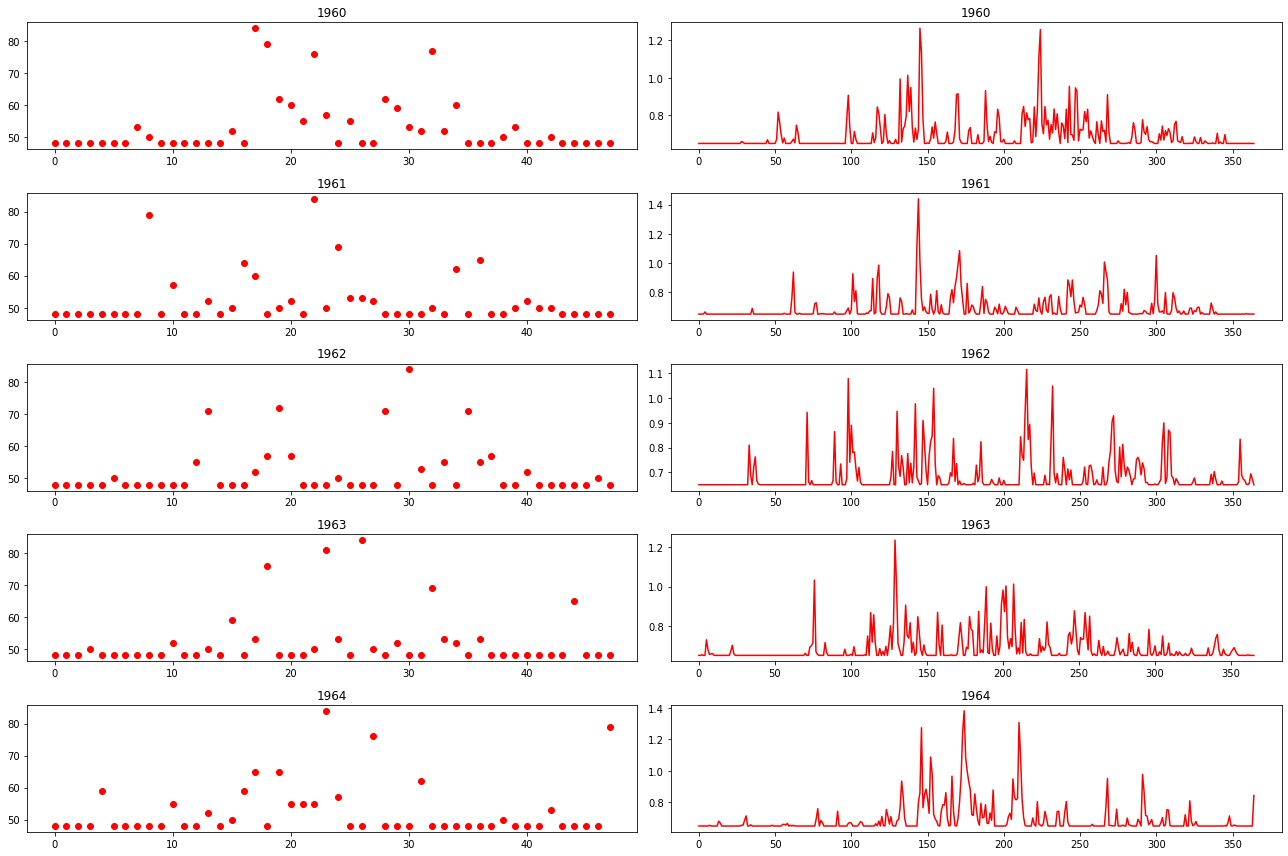

In [157]:
#My next idea is to get the Rain in as an average 3rd melody then have the other melodies play after it.
#We have to redo a few things though.

years = years 
diatonics = diatonics

midi_dict_rainyears = {} #Making a dictionary with each year and array
temp_data_rainagg = {} #Just for plotting purposes

target_n = 12*4 #Change this number, in samples per year

fig, ax =plt.subplots(len(years)-1, 2, figsize=(18,12))
for year in range(len(years)-1):
    start_date = '{}-06-30'.format(years[year])
    end_date = '{}-06-30'.format(years[year+1])
    print('Date Range:', start_date, end_date)
    
    data_4range = loc_on(start_date, end_date, df_norm)
    rain_data = data_4range['HJA Precipitation in mm/day'].values
    
    #Getting Sample
    step = int(len(rain_data)/target_n)
    slices = np.linspace(0, 365, target_n)

    #Set Outputs
    data = np.zeros(target_n)
    
    for i in range(len(slices)-1):
        data[i]=(rain_data[int(slices[i])])
    data[-1]=rain_data[-1]
    #nout = np.interp(data, (datamin, datamax), (0, len(diatonics)-1)) #Use this if you want year relative maps
    
    nout = np.interp(data, (np.min(data), np.max(data)), (0, len(diatonics)-1)) #Use this if you dont want relative maps
    
    out = np.zeros(len(nout)) #Set official out array

    for j in range(len(nout)):
        s = int(np.round(nout[j]))
        out[j] = diatonics[s]
            
    midi_dict_rainyears[years[year]] = out #THe final Out
    temp_data_rainagg[years[year]] = rain_data #Temporary
    
    ax[year][0].set_title(years[year])
    ax[year][0].plot(out, 'ro')
    
    ax[year][1].set_title(years[year])
    ax[year][1].plot(rain_data, 'r')
plt.tight_layout()

In [159]:
miditime = 0
rain_midi = MIDIFile(1, eventtime_is_ticks=True) #Making Rain file
rain_midi.addTempo(0, miditime, bpm)

for year in midi_dict_rainyears.keys():
    rain_midi, miditime = diatonic_midifile_destroy_duples(rain_midi, bpm, int(note_duration), midi_dict_rainyears[year], miditime)
    miditime += phrase_length

with open("MidiFiles/Hydrology2.0Tests/{}.mid".format('rain_noduplesTest'), "wb") as output_file:
    rain_midi.writeFile(output_file)
    
#Now we're onto something. I feel like it'll be better at a different rate, we need roughly 16notes per note.